# PathCond Demo

This notebook demonstrates **PathCond** (Path-Conditioned Training), a method that exploits rescaling symmetries of ReLU neural networks to accelerate training convergence.

We compare:
- **PathCond**: initial rescaling
- **Baseline**: standard SGD with no rescaling

on the classic two-moons binary classification benchmark.

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

from pathcond.pathcond import rescaling_path_cond

torch.manual_seed(0)
DEVICE = torch.device('cpu')

## 1. Model definition

A simple MLP with ReLU activations — the architecture on which PathCond's rescaling symmetry applies.

In [2]:
class MLP(nn.Module):
    def __init__(self, hidden_dims, seed=0):
        super().__init__()
        torch.manual_seed(seed)
        self.input_dim  = hidden_dims[0]
        self.output_dim = hidden_dims[-1]

        layers = []
        prev = self.input_dim
        for h in hidden_dims[1:-1]:
            layers += [nn.Linear(prev, h, bias=True), nn.ReLU()]
            prev = h
        layers.append(nn.Linear(prev, self.output_dim, bias=False))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## 2. Sanity check — PathCond preserves the input-output mapping

PathCond rescales the weights along neuron-wise directions that leave the network function **exactly unchanged**. This cell verifies that invariance.

In [12]:
demo_model = MLP([2, 16, 16, 2], seed=42)
x = torch.randn(4, 2)

out_before = demo_model(x).detach().clone()
rescaling_path_cond(demo_model)
out_after  = demo_model(x).detach()

max_diff = (out_before - out_after).abs().max().item()
print(f"Max absolute difference before/after rescaling: {max_diff:.2e}")
print("✓ Input-output mapping is numerically preserved." if max_diff < 1e-4 else "✗ Warning: outputs changed significantly.")

Max absolute difference before/after rescaling: 1.49e-08
✓ Input-output mapping is numerically preserved.


## 3. Dataset — Two Moons

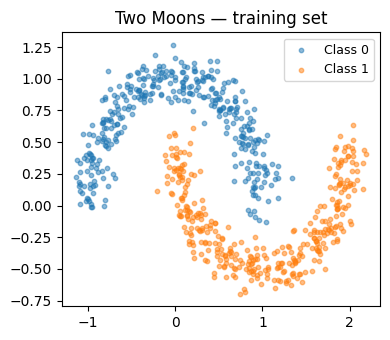

In [4]:
def moons_loaders(n_samples=1000, noise=0.1, seed=0):
    X, y = make_moons(n_samples=n_samples, noise=noise, random_state=seed)
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)
    return train_test_split(X, y, test_size=0.3, random_state=seed)

X_train, X_test, y_train, y_test = moons_loaders(seed=0)

fig, ax = plt.subplots(figsize=(4, 3.5))
ax.scatter(*X_train[y_train==0].T, s=10, alpha=0.5, label='Class 0')
ax.scatter(*X_train[y_train==1].T, s=10, alpha=0.5, label='Class 1')
ax.set_title('Two Moons — training set')
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

## 4. Training loop

Both models start from **identical initializations** (same seed). PathCond applies `rescaling_path_cond` only at init. The loss is cross-entropy for the actual classification task.

In [7]:
ARCH           = [2, 64, 64, 64, 64, 2]
NB_EPOCHS      = 3000
LR             = 1e-2

model_pathcond = MLP(ARCH, seed=0).to(DEVICE)
model_baseline = MLP(ARCH, seed=0).to(DEVICE)  # identical init

opt_pc   = torch.optim.SGD(model_pathcond.parameters(), lr=LR)
opt_base = torch.optim.SGD(model_baseline.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

X_tr, y_tr = X_train.to(DEVICE), y_train.to(DEVICE)
X_te, y_te = X_test.to(DEVICE),  y_test.to(DEVICE)

loss_pc,   loss_base   = [], []
acc_pc,    acc_base    = [], []

def accuracy(model, X, y):
    with torch.no_grad():
        return (model(X).argmax(1) == y).float().mean().item()

for epoch in range(NB_EPOCHS):
    # --- PathCond ---
    if epoch == 0:
        rescaling_path_cond(model_pathcond)

    model_pathcond.train()
    opt_pc.zero_grad()
    loss = criterion(model_pathcond(X_tr), y_tr)
    loss.backward()
    opt_pc.step()
    loss_pc.append(loss.item())

    # --- Baseline ---
    model_baseline.train()
    opt_base.zero_grad()
    loss = criterion(model_baseline(X_tr), y_tr)
    loss.backward()
    opt_base.step()
    loss_base.append(loss.item())

    if (epoch + 1) % 500 == 0:
        acc_pc_val   = accuracy(model_pathcond, X_te, y_te)
        acc_base_val = accuracy(model_baseline, X_te, y_te)
        print(f"Epoch {epoch+1:5d} | "
              f"Loss PathCond: {loss_pc[-1]:.4f}  Acc: {acc_pc_val:.3f} | "
              f"Loss Baseline: {loss_base[-1]:.4f}  Acc: {acc_base_val:.3f}")

print("\nFinal test accuracy:")
print(f"  PathCond : {accuracy(model_pathcond, X_te, y_te):.4f}")
print(f"  Baseline : {accuracy(model_baseline, X_te, y_te):.4f}")

Epoch   500 | Loss PathCond: 0.2444  Acc: 0.883 | Loss Baseline: 0.3838  Acc: 0.850
Epoch  1000 | Loss PathCond: 0.1656  Acc: 0.920 | Loss Baseline: 0.2146  Acc: 0.893
Epoch  1500 | Loss PathCond: 0.0624  Acc: 0.980 | Loss Baseline: 0.1459  Acc: 0.930
Epoch  2000 | Loss PathCond: 0.0238  Acc: 0.993 | Loss Baseline: 0.0638  Acc: 0.980
Epoch  2500 | Loss PathCond: 0.0133  Acc: 0.997 | Loss Baseline: 0.0263  Acc: 0.993
Epoch  3000 | Loss PathCond: 0.0087  Acc: 0.997 | Loss Baseline: 0.0149  Acc: 0.997

Final test accuracy:
  PathCond : 0.9967
  Baseline : 0.9967


## 5. Results

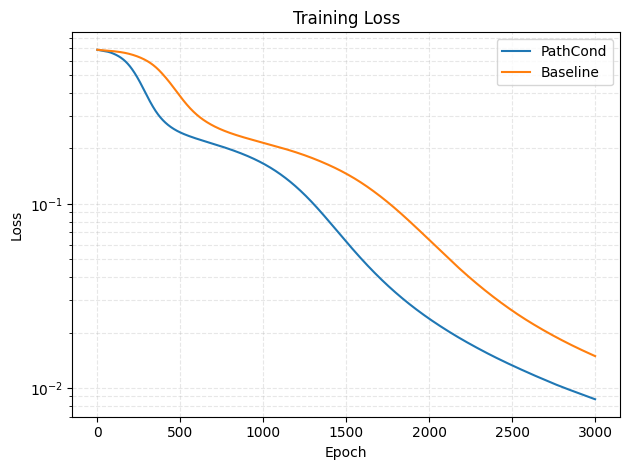

In [11]:
plt.plot(loss_pc, label="PathCond")
plt.plot(loss_base, label="Baseline")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss")
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.tight_layout()
plt.show()